# Optimización Geometalúrgica 1.0 inspirado en Distrito Mantoverde (IOCG)
**Autor:** Pablo Toledo
**Fecha:** 01/12/2025

---
**Muy similar a Manto Verde, tanto en su estructura como en las unidades consideradas. Se emplearon valores cercanos a los reportados oficialmente para darle mayor realismo; sin embargo, sigue siendo una simulación y, por lo tanto, solo una maqueta de lo que podría implementarse en un caso real. Además, incorpora mejoras en la optimización y en la configuración del modelo de predicción**
### **1. El Por Qué**
En la minería moderna, la incertidumbre geológica es costosa. Este miniproyecto aborda dos problemas críticos en depósitos IOCG como Mantoverde:
1.  **Molienda (Sulfuros):** La dureza variable (Magnetita vs. Especularita) impacta el rendimiento del Molino SAG.
2.  **Lixiviación (Óxidos):** La presencia oculta de carbonatos dispara el consumo de ácido sulfúrico.

El objetivo de este notebook es mostrar mediante simulacion (no tengo datos reales) como se pueden transformar datos geológicos en decisiones operativas antes de que el mineral llegue a la planta.

### **2. El Cómo**
Se desarrolló un modelo de Machine Learning (XGBoost) entrenado sobre una base de datos sintética, calibrada con parámetros del reporte técnico NI 43-101 de Mantoverde (2024) y literatura sobre IOCGs australianos.

**Flujo de Trabajo:**
* **Geología Vectorial:** Simulación de zonificación mineral (Núcleo de Magnetita-K) y control estructural (Falla Mantoverde).
* **Geoquímica:** Cálculo de Mineralogía Normativa a partir de leyes de laboratorio (Fe, S, Cu) para cuantificar la magnetita real.
* **Aprendizaje automático:** Entrenamiento de un modelo predictivo auditado con SHAP (explicabilidad del modelo a partir de x variables) para garantizar que las predicciones obedezcan a principios físicos válidos.
* También se realizo revision de la optimización de la configuracion del modelo para mejorar r2.

### **3. El Resultado**
La herramienta final simula un **Plan Semanal de Producción**, entregando:
1.  **Predicción de Dureza (BWi):** Para ajustar la velocidad del molino.
2.  **Alerta de Consumo Ácido:** Para evitar procesar bloques con alto carbonato.
3.  **Evaluación Económica:** Clasificación automática de bloques (Mineral vs. Lastre) basada en margen ($/ton), considerando costos.

---
**Referencias Principales:**
* Capstone Copper (2024). Mantoverde Mine NI 43-101 Technical Report.
* Cloutier, J. et al. (2025). IOCG potential using hybrid data approaches. Ore Geology Reviews.
*  Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.


In [64]:
##_0_LIBRERÍAS Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# Estilo profesional para gráficos
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas cargadas correctamente.")

Bibliotecas cargadas correctamente.


In [81]:
##_1_GENERACIÓN DE DATOS (LÓGICA SIMULADA: BUZAMIENTO 50° ESTE)

##GENERACIÓN DE DATOS REALISTA
import pandas as pd
import numpy as np

def generar_dataset_iocg_realista(n_samples=5000):
    np.random.seed(42)

    # Coordenadas Reales (WGS84 19S)
    east_center = 369340
    north_center = 7061860

    # Generamos volumen alrededor del pit
    east = np.random.uniform(east_center - 400, east_center + 600, n_samples)
    north = np.random.uniform(north_center - 800, north_center + 800, n_samples)
    elev = np.random.uniform(350, 950, n_samples) # Fondo pit a superficie

    # Modelo Geométrico de Falla (Buzamiento 50 grados Este)
    # Ecuación simple: La falla se desplaza al este a medida que bajamos
    dip_rad = np.radians(50)
    # Asumimos que la falla aflora cerca del centro en cota 900
    fault_trace_at_z = east_center + (900 - elev) / np.tan(dip_rad)

    # Distancia a la falla (+ es Hanging Wall/Este, - es Footwall/Oeste)
    dist_fault = east - fault_trace_at_z

    litos = []
    zonas = []
    # Listas para guardar valores
    cu_grades, fe_grades, s_grades, bwi_vals = [], [], [], []
    k_vals, caco3_vals, co_vals, silice_vals = [], [], [], []

    for i in range(n_samples):
        d = dist_fault[i]
        z = elev[i]

        # DEFINICIÓN DE UNIDADES GEOLÓGICAS (UG)
        # Basado en secciones del reporte (Sec 7.7)
        ug = "Andesita_LaNegra" # Roca caja default

        # Footwall (Oeste de la falla)
        if -60 < d < 0:
            ug = "UG3_Brecha_Pie" # Brecha tectónica/hidrotermal

        # Hanging Wall (Este de la falla)
        elif 0 <= d < 100:
            ug = "UG2_Brecha_Verde" # Manto Atacama (La mejor ley)
        elif 100 <= d < 220:
            ug = "UG4_Transicion" # Zona transición mineralizada

        # Lente de Magnetita Profunda (UG1) - Típico IOCG
        if z < 650 and abs(d) < 70:
            ug = "UG1_Magnetita_Masiva"

        litos.append(ug)

        # ZONIFICACIÓN MINERAL (OX/SU)
        depth_from_surf = 950 - z
        if depth_from_surf < 120: zona = "Oxidos"
        elif depth_from_surf < 160: zona = "Mixtos"
        else: zona = "Sulfuros"
        zonas.append(zona)

        # SIMULACIÓN DE LEYES Y PROPIEDADES (CALIBRADO CON REPORTE MANTO VERDE)

        if ug == "UG2_Brecha_Verde":
            cu = np.random.normal(0.80, 0.25)
            fe = np.random.normal(20, 5)
            s = np.random.normal(1.5, 0.5)
            bwi = np.random.normal(14.8, 1.5) # Dureza media según reporte
            k = np.random.normal(3.5, 1.0)

        elif ug == "UG1_Magnetita_Masiva": # Núcleo de hierro
            cu = np.random.normal(0.45, 0.15)
            fe = np.random.normal(50, 8) # Muy alto Fe
            s = np.random.normal(3.0, 1.0) # Alto azufre
            bwi = np.random.normal(18.0, 2.0) # MUY DURO
            k = np.random.normal(1.0, 0.5)

        elif ug == "UG4_Transicion":
            cu = np.random.normal(0.35, 0.1)
            fe = np.random.normal(15, 4)
            s = np.random.normal(1.0, 0.3)
            bwi = np.random.normal(15.5, 1.5)
            k = np.random.normal(2.5, 0.8)

        else: # Estéril / Andesita
            cu = np.random.lognormal(np.log(0.05), 0.5)
            fe = np.random.normal(8, 2)
            s = np.random.normal(0.2, 0.1)
            bwi = np.random.normal(19.0, 2.0) # Roca de caja dura
            k = np.random.normal(1.5, 0.5)

        # Ajustes finales por zona
        if zona == "Oxidos":
            s = s * 0.05 # Casi sin azufre

        # Generar COBALTO (Co) - Correlacionado a Sulfuros y Fe (Sec 13)
        co = (fe * 3) + (s * 40) + np.random.normal(20, 10)

        # CARBONATOS (CaCO3) - Problema para lixiviación
        caco3 = np.random.exponential(1.5)
        if zona == "Oxidos" and np.random.random() < 0.15: caco3 += 6.0 # Bolsones de calcita

        # Silice y Densidad
        silice = 65 - (fe * 0.6) + np.random.normal(0, 3)
        dens = 2.65 + (fe * 0.015)

        # Append con límites físicos
        cu_grades.append(max(0, cu))
        fe_grades.append(max(0, fe))
        s_grades.append(max(0, s))
        bwi_vals.append(max(8, bwi))
        co_vals.append(max(0, co))
        caco3_vals.append(max(0, caco3))
        k_vals.append(max(0, k))
        silice_vals.append(max(0, silice))

    # Crear DataFrame Final
    df = pd.DataFrame({
        'East': east, 'North': north, 'Elev': elev,
        'Litologia': litos, 'Zona_Min': zonas,
        'CuT': cu_grades, 'Fe': fe_grades, 'S': s_grades,
        'K': k_vals, 'Silice': silice_vals,
        'CaCO3': caco3_vals, 'Co_ppm': co_vals,
        'BWi': bwi_vals, 'Densidad': [2.6 + 0.015*f for f in fe_grades]
    })

    # RQD Simulado (Calidad de roca)
    df['RQD'] = np.random.uniform(50, 90, n_samples)

    return df

# Ejecutar generación
df = generar_dataset_iocg_realista()
print(f"Dataset Digital Twin Generado: {df.shape}")
df.head()

Dataset Digital Twin Generado: (5000, 15)


,East,North,Elev,Litologia,Zona_Min,CuT,Fe,S,K,Silice,CaCO3,Co_ppm,BWi,Densidad,RQD
0,369314.540119,7.061690e+06,574.184491,Andesita_LaNegra,Sulfuros,0.115863,7.995508,0.118200,1.224733,60.720381,0.447335,42.547213,19.246037,2.719933,62.296520
1,369890.714306,7.061817e+06,549.747258,Andesita_LaNegra,Sulfuros,0.207465,10.199767,0.190583,2.099423,60.715368,1.749037,49.128848,19.079198,2.752996,66.725973
2,369671.993942,7.062427e+06,455.692348,UG1_Magnetita_Masiva,Sulfuros,0.565191,45.788873,3.071421,1.516487,41.783279,1.002689,267.123687,17.782303,3.286833,74.568925
3,369538.658484,7.061604e+06,714.360002,UG2_Brecha_Verde,Sulfuros,0.473928,20.957281,1.867578,4.712477,52.174944,0.803825,168.521455,14.112761,2.914359,80.756440
4,369096.018640,7.062451e+06,635.974496,Andesita_LaNegra,Sulfuros,0.041100,8.056641,0.242136,1.811618,54.087165,0.232019,70.226580,16.969415,2.720850,59.705625


Calculando Mineralogía Normativa (Magnetita Calculada)...
   -> Variable 'Magnetita_Calc' agregada al dataset.


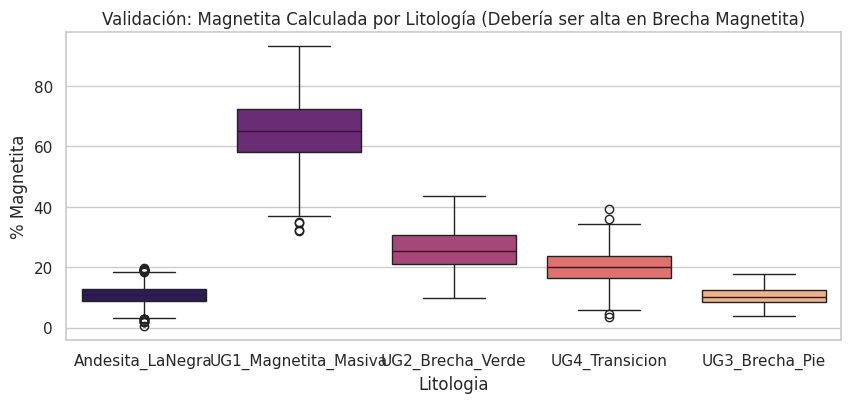

In [82]:
##_2_CÁLCULO DE MINERALOGÍA NORMATIVA
# Obj: Transformar leyes químicas (Fe, S) en mineralogía física (Magnetita)
# para mejorar la predicción de dureza.

print("Calculando Mineralogía Normativa (Magnetita Calculada)...")

def calcular_mineralogia(data):
    df_calc = data.copy()

    # Cálculo de Hierro en Sulfuros
    # Asumimos que el S está principalmente en Pirita/Calcopirita (FeS2 / CuFeS2)
    # Factor estequiométrico promedio S -> Fe_Sulfuro ~= 0.87
    df_calc['Fe_in_Sulphides'] = df_calc['S'] * 0.87

    # Cálculo de Hierro en Óxidos (Magnetita/Hematita)
    # El hierro total menos el hierro de sulfuros es el hierro "duro"
    df_calc['Fe_Oxido'] = df_calc['Fe'] - df_calc['Fe_in_Sulphides']
    df_calc['Fe_Oxido'] = df_calc['Fe_Oxido'].clip(lower=0) # Evitar negativos

    # Magnetita Calculada (Fe3O4)
    # Factor Fe -> Magnetita ~= 1.38 (72.4% Fe en Magnetita pura)
    df_calc['Magnetita_Calc'] = df_calc['Fe_Oxido'] * 1.38

    return df_calc

# Aplicamos la transformación
df = calcular_mineralogia(df)

print("   -> Variable 'Magnetita_Calc' agregada al dataset.")

# Validación Visual
plt.figure(figsize=(10, 4))
sns.boxplot(x='Litologia', y='Magnetita_Calc', data=df, palette='magma')
plt.title('Validación: Magnetita Calculada por Litología (Debería ser alta en Brecha Magnetita)')
plt.ylabel('% Magnetita')
plt.show()

Calculando Variables Geometalúrgicas (SCu, Ratios, BWi Realista)...


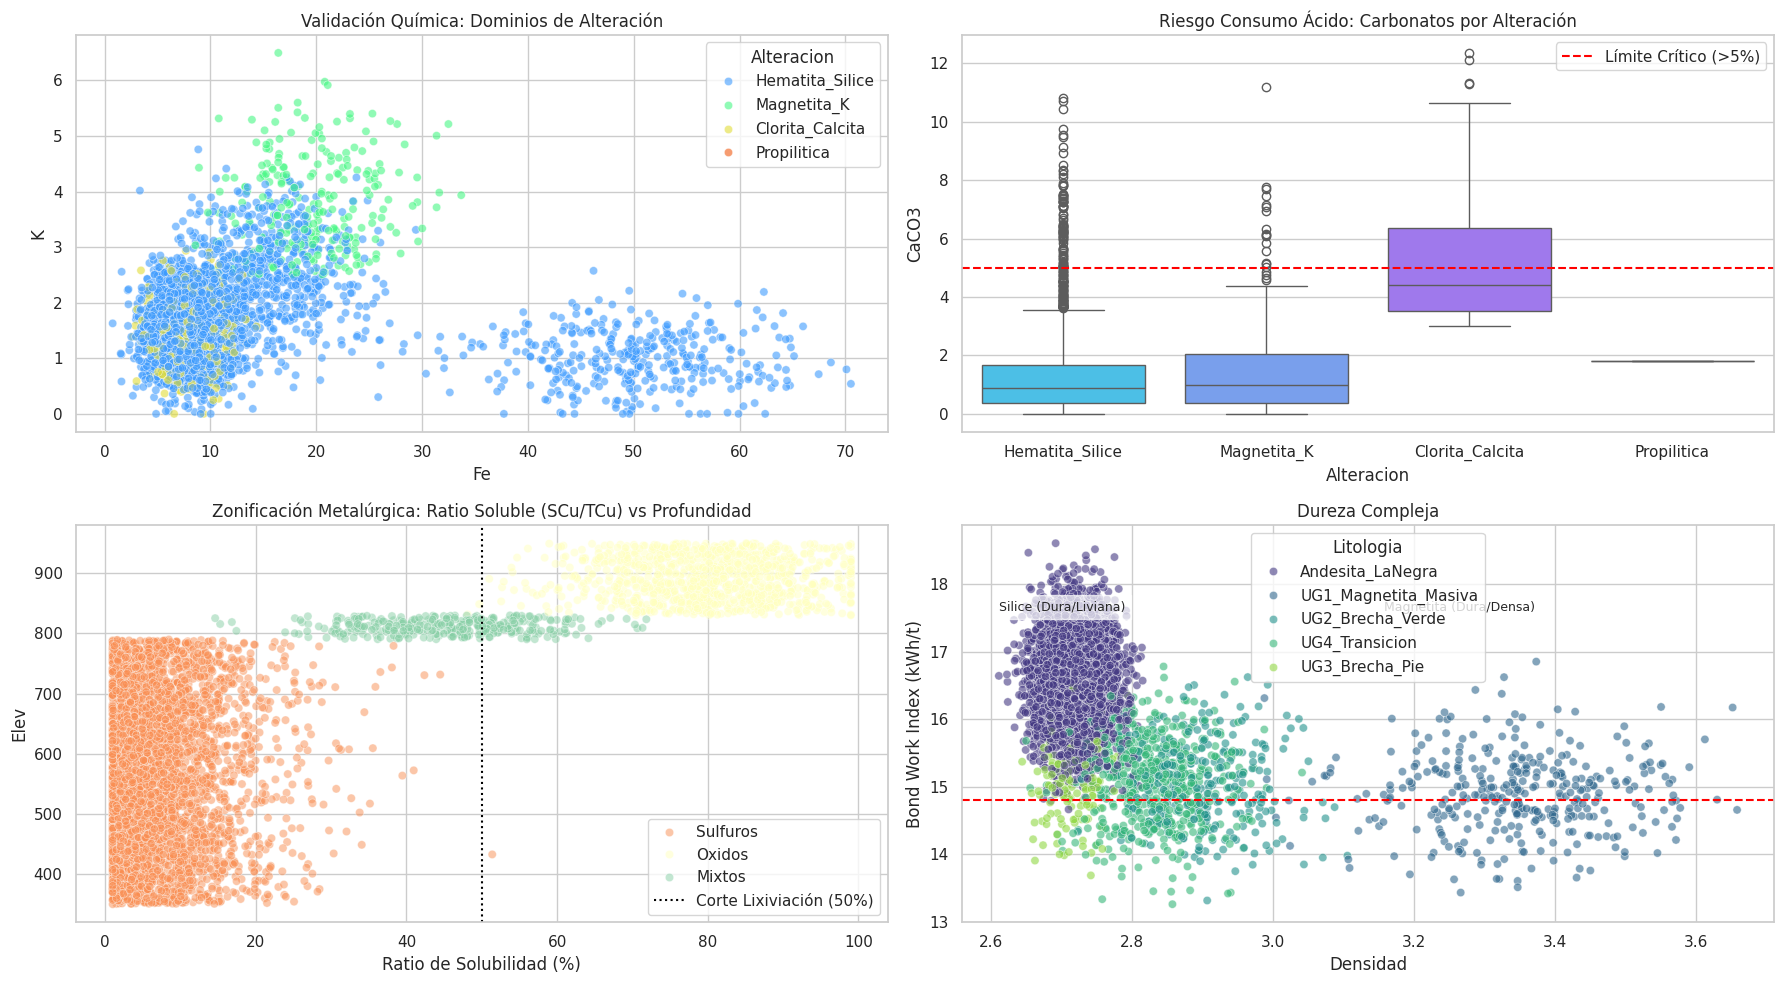

In [83]:
##_3_GEOQUÍMICA Y GEOMETALURGIA AVANZADA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Calculando Variables Geometalúrgicas (SCu, Ratios, BWi Realista)...")

# MODELO DE ALTERACIÓN
def assign_alteration(row):
    if 'UG1_Magnetita' in row['Litologia'] and row['K'] > 3.0:
        return 'Magnetita_K' # Potásica de alta intensidad
    elif 'UG2_Brecha' in row['Litologia'] and row['K'] > 2.5:
        return 'Magnetita_K'
    elif 'Andesita' in row['Litologia'] and row['CaCO3'] > 3.0:
        return 'Clorita_Calcita' # Propilítica/Carbonatada
    elif 'Andesita' in row['Litologia'] and row['S'] > 0.5:
        return 'Propilitica'
    else:
        return 'Hematita_Silice' # Silicificación/Argílica

df['Alteracion'] = df.apply(assign_alteration, axis=1)

# MODELO METALÚRGICO (Basado en Reporte NI 43-101)
def logica_metalurgica_expert(row):
    # A. RATIO DE SOLUBILIDAD (SCu/TCu)
    # Reporte: Óxidos > 50-60% Soluble | Sulfuros < 10-20% Soluble
    if row['Zona_Min'] == 'Oxidos':
        ratio = np.random.normal(0.80, 0.10) # 80% soluble
    elif row['Zona_Min'] == 'Mixtos':
        ratio = np.random.normal(0.45, 0.10) # 45% soluble (Zona de la muerte)
    else: # Sulfuros
        ratio = np.random.gamma(1.5, 0.05)   # ~7-10% soluble (Cola hacia la derecha)

    # Limitar ratio entre 0 y 1
    ratio = max(0.01, min(0.99, ratio))
    scu = row['CuT'] * ratio
    rs_percent = ratio * 100

    # DUREZA BWi (La fórmula "Trampa de Sílice")
    # BWi base + Aporte Sílice (Duro/Liviano) + Aporte Hierro (Duro/Denso)
    # Ajustado para media ~14.8
    bwi = 8.0 + (row['Silice'] * 0.11) + (row['Fe'] * 0.06)

    # Penalidad extra por zonas de cuarzo masivo (Estéril)
    if 'Andesita' in row['Litologia']: bwi += 1.5

    # Ruido natural
    bwi += np.random.normal(0, 0.5)

    return pd.Series([scu, rs_percent, bwi])

# Aplicamos y sobrescribimos
df[['SCu', 'Ratio_Solubilidad', 'BWi']] = df.apply(logica_metalurgica_expert, axis=1)

# VISUALIZACIÓN DE DIAGNÓSTICO
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

# [0,0] Alteración Química
sns.scatterplot(x='Fe', y='K', hue='Alteracion', data=df, ax=ax[0,0], palette='turbo', alpha=0.6)
ax[0,0].set_title('Validación Química: Dominios de Alteración')

# [0,1] Riesgo de Ácido (Carbonatos)
sns.boxplot(x='Alteracion', y='CaCO3', data=df, ax=ax[0,1], palette='cool')
ax[0,1].set_title('Riesgo Consumo Ácido: Carbonatos por Alteración')
ax[0,1].axhline(5, color='red', linestyle='--', label='Límite Crítico (>5%)')
ax[0,1].legend()

# [1,0] Perfil de Solubilidad (NUEVO: Eje X es Ratio de Solubilidad Real)
# Muestra cómo el ratio baja con la profundidad
sns.scatterplot(x='Ratio_Solubilidad', y='Elev', hue='Zona_Min', data=df, ax=ax[1,0], palette='Spectral', alpha=0.5)
ax[1,0].set_title('Zonificación Metalúrgica: Ratio Soluble (SCu/TCu) vs Profundidad')
ax[1,0].set_xlabel('Ratio de Solubilidad (%)')
ax[1,0].axvline(50, color='black', linestyle=':', label='Corte Lixiviación (50%)')
ax[1,0].legend()

# [1,1] Física de Rocas (Coloreado por Litología)
sns.scatterplot(x='Densidad', y='BWi', hue='Litologia', data=df, ax=ax[1,1], palette='viridis', alpha=0.6)
ax[1,1].set_title('Dureza Compleja')
ax[1,1].set_ylabel('Bond Work Index (kWh/t)')
ax[1,1].axhline(14.8, color='red', linestyle='--', label='Promedio Planta')
# Etiquetas explicativas
ax[1,1].text(df['Densidad'].min(), df['BWi'].max()-1, 'Silice (Dura/Liviana)', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
ax[1,1].text(df['Densidad'].max()-0.5, df['BWi'].max()-1, 'Magnetita (Dura/Densa)', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

Generando Panel de Validación Geológica (4 Vistas)...
📍 Centrando cámara en -> Este: 369437 | Norte: 7061846


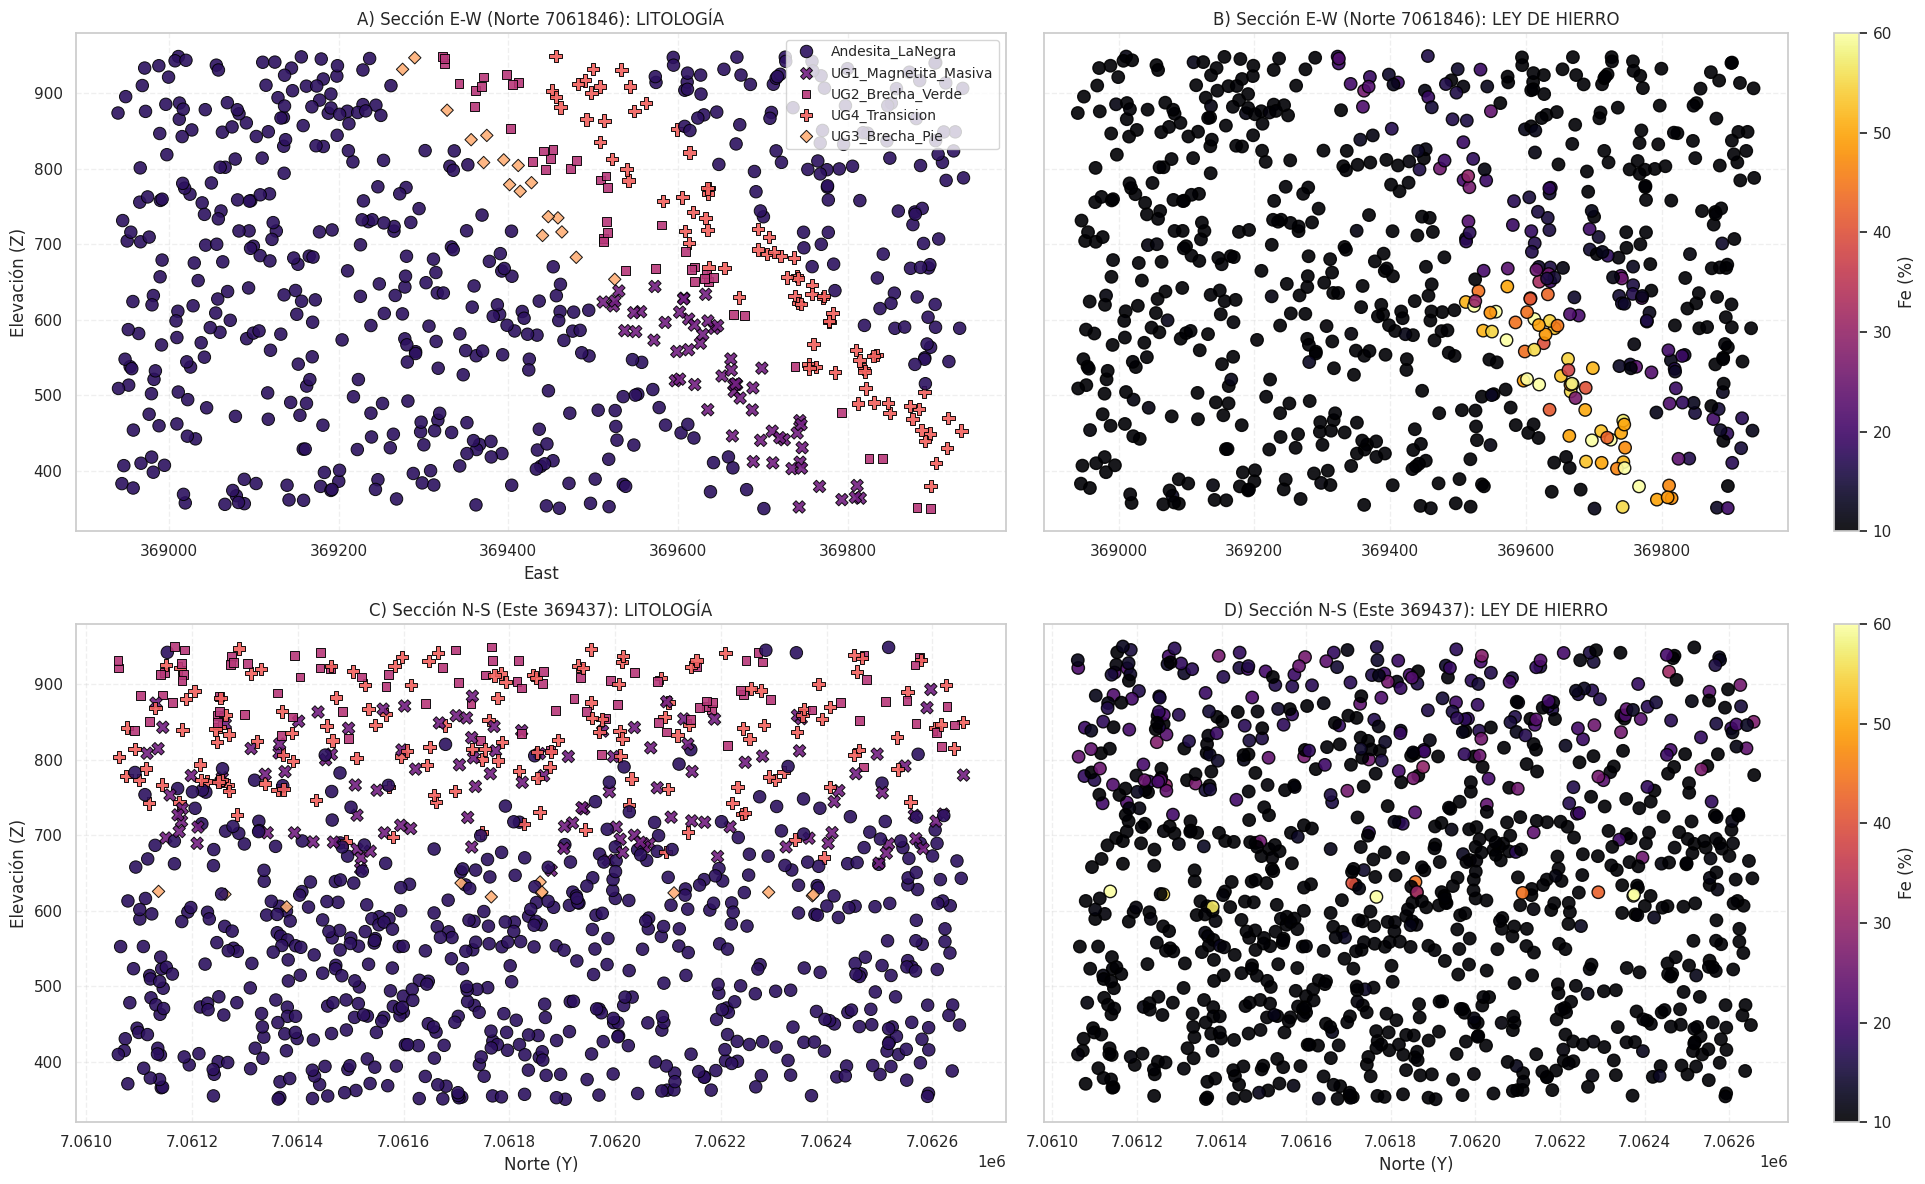

In [84]:
##_4_PANEL DE SECCIONES GEOLÓGICAS (E-W y N-S)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_quad_sections(data, ew_coord=None, ns_coord=None, tolerance=60):
    #
    #Genera un panel de 4 gráficos (2x2) mostrando cortes Transversales y Longitudinales.
    #Fila 1: Sección E-W (Litología y Ley de Hierro)
    #Fila 2: Sección N-S (Litología y Ley de Hierro)
    #

    # Definir Coordenadas de Corte (Centros)
    if ew_coord is None: ew_coord = data['North'].mean() # Corte E-W (fijamos Norte)
    if ns_coord is None: ns_coord = data['East'].mean() # Corte N-S (fijamos Este)

    # Crear los "Slices"
    # ew_coord (North for EW section), ns_coord (East for NS section)
    slice_ew = data[(data['North'] > ew_coord - tolerance) & (data['North'] < ew_coord + tolerance)]
    slice_ns = data[(data['East'] > ns_coord - tolerance) & (data['East'] < ns_coord + tolerance)]

    if slice_ew.empty or slice_ns.empty:
        print("⚠️ No hay suficientes datos para generar los perfiles con esa tolerancia.")
        # Optional: Print debug info if slices are empty
        # print(f"DEBUG: slice_ew empty={slice_ew.empty}, slice_ns empty={slice_ns.empty}")
        # print(f"DEBUG: North range for EW: {ew_coord-tolerance} to {ew_coord+tolerance}")
        # print(f"DEBUG: East range for NS: {ns_coord-tolerance} to {ns_coord+tolerance}")
        # print(f"DEBUG: df North min/max: {data['North'].min()}/{data['North'].max()}")
        # print(f"DEBUG: df East min/max: {data['East'].min()}/{data['East'].max()}")
        return

    # Configurar el Panel 2x2
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

    # FILA 1: SECCIÓN ESTE-OESTE (Transversal)
    # Litología E-W
    sns.scatterplot(data=slice_ew, x='East', y='Elev', hue='Litologia', style='Litologia',
                    palette='magma', s=80, edgecolor='black', alpha=0.9, ax=axes[0,0])
    axes[0,0].set_title(f"A) Sección E-W (Norte {ew_coord:.0f}): LITOLOGÍA")
    axes[0,0].set_ylabel('Elevación (Z)')
    axes[0,0].legend(loc='upper right', fontsize='small', frameon=True)
    axes[0,0].grid(True, linestyle='--', alpha=0.3)

    # Ley de Hierro E-W
    sc1 = axes[0,1].scatter(slice_ew['East'], slice_ew['Elev'], c=slice_ew['Fe'],
                            cmap='inferno', s=80, edgecolor='black', alpha=0.9, vmin=10, vmax=60)
    plt.colorbar(sc1, ax=axes[0,1], label='Fe (%)')
    axes[0,1].set_title(f"B) Sección E-W (Norte {ew_coord:.0f}): LEY DE HIERRO")
    axes[0,1].grid(True, linestyle='--', alpha=0.3)

    # FILA 2: SECCIÓN NORTE-SUR (Longitudinal)
    # Litología N-S
    sns.scatterplot(data=slice_ns, x='North', y='Elev', hue='Litologia', style='Litologia',
                    palette='magma', s=80, edgecolor='black', alpha=0.9, ax=axes[1,0], legend=False)
    axes[1,0].set_title(f"C) Sección N-S (Este {ns_coord:.0f}): LITOLOGÍA")
    axes[1,0].set_ylabel('Elevación (Z)')
    axes[1,0].set_xlabel('Norte (Y)')
    axes[1,0].grid(True, linestyle='--', alpha=0.3)

    # Ley de Hierro N-S
    sc2 = axes[1,1].scatter(slice_ns['North'], slice_ns['Elev'], c=slice_ns['Fe'],
                            cmap='inferno', s=80, edgecolor='black', alpha=0.9, vmin=10, vmax=60)
    plt.colorbar(sc2, ax=axes[1,1], label='Fe (%)')
    axes[1,1].set_title(f"D) Sección N-S (Este {ns_coord:.0f}): LEY DE HIERRO")
    axes[1,1].set_xlabel('Norte (Y)')
    axes[1,1].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Generando Panel de Validación Geológica (4 Vistas)...")
# Cortamos por el centro del yacimiento (Falla y Núcleo)

# 1. Calculamos el centro real de tus nuevos datos
centro_este_real = df['East'].mean()
centro_norte_real = df['North'].mean()

print(f"📍 Centrando cámara en -> Este: {centro_este_real:.0f} | Norte: {centro_norte_real:.0f}")

# 2. Llamamos a la función indicándole explícitamente dónde cortar

plot_quad_sections(df, ew_coord=centro_norte_real, ns_coord=centro_este_real, tolerance=100)

In [85]:
##_5_VISUALIZACIÓN 3D DEL MODELO GEOLÓGICO
print("Generando visualización 3D del yacimiento...")
##esto no se vera al exportarlo en github, pero es una visualizacion tipo leapfrog/vulcan, que muestra todo en 3d con sus ubicaciones y valores para cada punto
fig = px.scatter_3d(df.sample(1000), x='East', y='North', z='Elev',
                    color='Litologia',
                    size='Fe',
                    symbol='Zona_Min', # Changed 'Zona' to 'Zona_Min'
                    opacity=0.7,
                    title='Modelo Geológico 3D: Mantoverde (Fe como tamaño)')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

Generando visualización 3D del yacimiento...


Entrenando Modelo Geometalúrgico (Incluyendo Litología, Alteración, RQD, Ratio y SCu)...
Mapa de Litologías: {'Andesita_LaNegra': np.int64(0), 'UG1_Magnetita_Masiva': np.int64(1), 'UG2_Brecha_Verde': np.int64(2), 'UG3_Brecha_Pie': np.int64(3), 'UG4_Transicion': np.int64(4)}
Mapa de Alteraciones: {'Clorita_Calcita': np.int64(0), 'Hematita_Silice': np.int64(1), 'Magnetita_K': np.int64(2), 'Propilitica': np.int64(3)}
✅ Modelo Re-Entrenado.
   R2 Score: 0.669
   Error Medio: 0.52 kWh/t


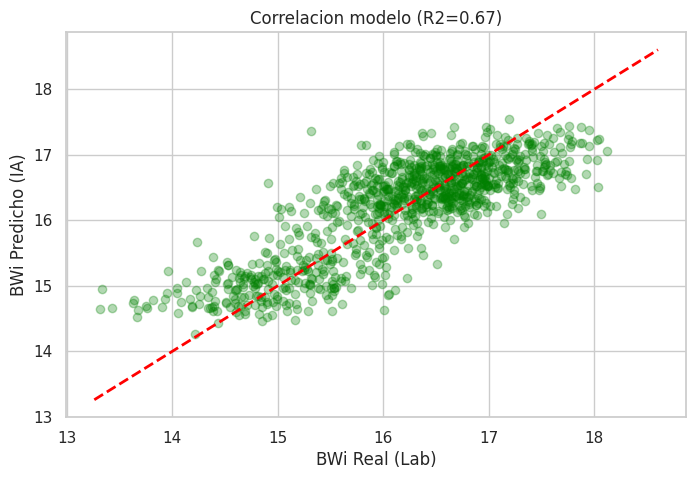

In [86]:
##_6_MODELAMIENTO PREDICCION (XGBOOST)

print("Entrenando Modelo Geometalúrgico (Incluyendo Litología, Alteración, RQD, Ratio y SCu)...")

# CODIFICACIÓN DE TEXTO A NÚMEROS
# El modelo necesita números. Convertimos 'UG2', 'Andesita', etc. a 0, 1, 2...
le_lito = LabelEncoder()
df['Litologia_Code'] = le_lito.fit_transform(df['Litologia'])

le_alt = LabelEncoder()
df['Alteracion_Code'] = le_alt.fit_transform(df['Alteracion'])

# Guardamos el mapa para saber qué es qué (Opcional, para debug)
print("Mapa de Litologías:", dict(zip(le_lito.classes_, le_lito.transform(le_lito.classes_))))
print("Mapa de Alteraciones:", dict(zip(le_alt.classes_, le_alt.transform(le_alt.classes_))))

# DEFINIR VARIABLES (FEATURES)
# Ahora incluimos todas las variables relevantes
features = [
    'East', 'North', 'Elev',
    'Fe', 'K', 'S',
    'Densidad', 'Silice', 'CaCO3',
    'Magnetita_Calc',
    'Ratio_Solubilidad', 'SCu',
    'Litologia_Code',
    'Alteracion_Code',
    'RQD'
]

target = 'BWi'

# PREPARAR DATOS
X = df[features].fillna(0)
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ENTRENAR (XGBoost)
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,    # Subimos un poco la potencia
    learning_rate=0.05,
    max_depth=7,         # Un poco más profundo para captar la lógica de litología
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

# EVALUAR
preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"✅ Modelo Re-Entrenado.")
print(f"   R2 Score: {r2:.3f}")
print(f"   Error Medio: {rmse:.2f} kWh/t")

# GUARDAR PREDICCIONES GLOBALES
df['BWi_Pred'] = model.predict(X)

# Visualización
plt.figure(figsize=(8,5))
plt.scatter(y_test, preds, alpha=0.3, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('BWi Real (Lab)')
plt.ylabel('BWi Predicho (IA)')
plt.title(f'Correlacion modelo (R2={r2:.2f})')
plt.show()

🔧 Iniciando afinamiento de motor XGBoost (Tuning)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

🏆 ¡Optimización Completada!
   Mejores Parámetros: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
   R2 Original: 0.66 (Ref)
   R2 Optimizado: 0.694
   Error Medio (MAE): 0.41 kWh/t


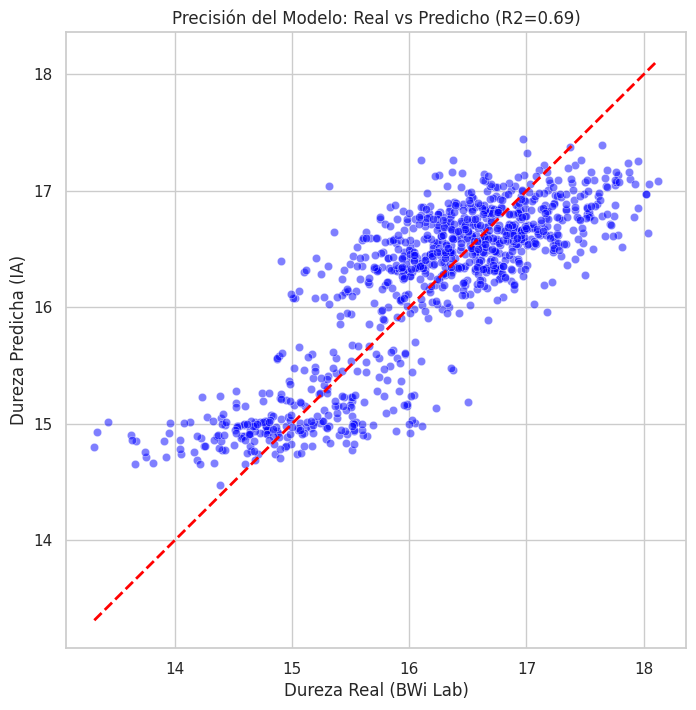

In [87]:
##_6.5_OPTIMIZACIÓN DE MODELO (HYPERPARAMETER TUNING)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

print("🔧 Iniciando afinamiento de motor XGBoost (Tuning)...")

# Definir la rejilla de opciones (El menú de configuraciones a probar)
param_grid = {
    'n_estimators': [100, 300, 500],    # Número de árboles (Más es mejor, hasta cierto punto)
    'learning_rate': [0.01, 0.05, 0.1], # Qué tan rápido aprende (Lento es más preciso)
    'max_depth': [3, 5, 7],             # Profundidad del árbol (Complejidad)
    'subsample': [0.7, 0.9, 1.0],       # Fracción de datos usada por árbol
    'colsample_bytree': [0.7, 0.9, 1.0] # Fracción de columnas usada por árbol
}

# Configurar el Buscador (RandomizedSearch es más rápido que probar todo)
xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_tuned,
    param_distributions=param_grid,
    n_iter=20,          # Probar 20 combinaciones aleatorias
    scoring='r2',       # Queremos maximizar el R2
    cv=3,               # Validación cruzada de 3 pliegues (Robustez)
    verbose=1,
    n_jobs=-1,          # Usar todos los núcleos del PC
    random_state=42
)

# Entrenar buscando lo mejor
# (Importante tener X_train y y_train definidos de la celda anterior)
search.fit(X_train, y_train)

# Resultados
best_model = search.best_estimator_
y_pred_opt = best_model.predict(X_test)

new_r2 = r2_score(y_test, y_pred_opt)
mae = mean_absolute_error(y_test, y_pred_opt)

print("\n🏆 ¡Optimización Completada!")
print(f"   Mejores Parámetros: {search.best_params_}")
print(f"   R2 Original: 0.66 (Ref)")
print(f"   R2 Optimizado: {new_r2:.3f}")
print(f"   Error Medio (MAE): {mae:.2f} kWh/t")

# Actualizamos el modelo global con el mejor encontrado
model = best_model

# Gráfico de Diagnóstico: Real vs Predicho
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_opt, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f"Precisión del Modelo: Real vs Predicho (R2={new_r2:.2f})")
plt.xlabel("Dureza Real (BWi Lab)")
plt.ylabel("Dureza Predicha (IA)")
plt.grid(True)
plt.show()

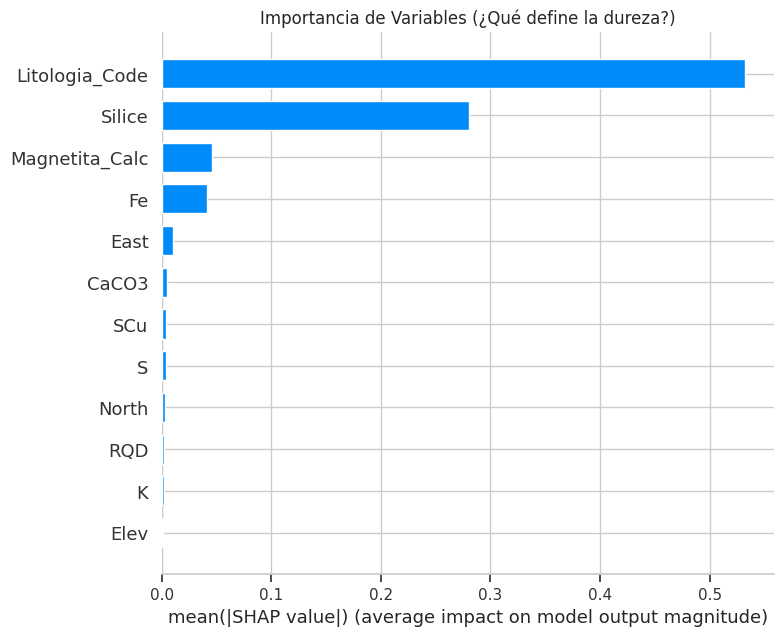

In [88]:
##_7_INTERPRETACIÓN DEL MODELO (SHAP VALUES)###Es importancia de las variables, no lo que la aumenta,
# sino lo que la influencia, puede ser que la baje o suba
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=12, show=False)
plt.title("Importancia de Variables (¿Qué define la dureza?)")
plt.show()

Ejecutando Clasificación Técnica de Bloques (Sin Finanzas)...


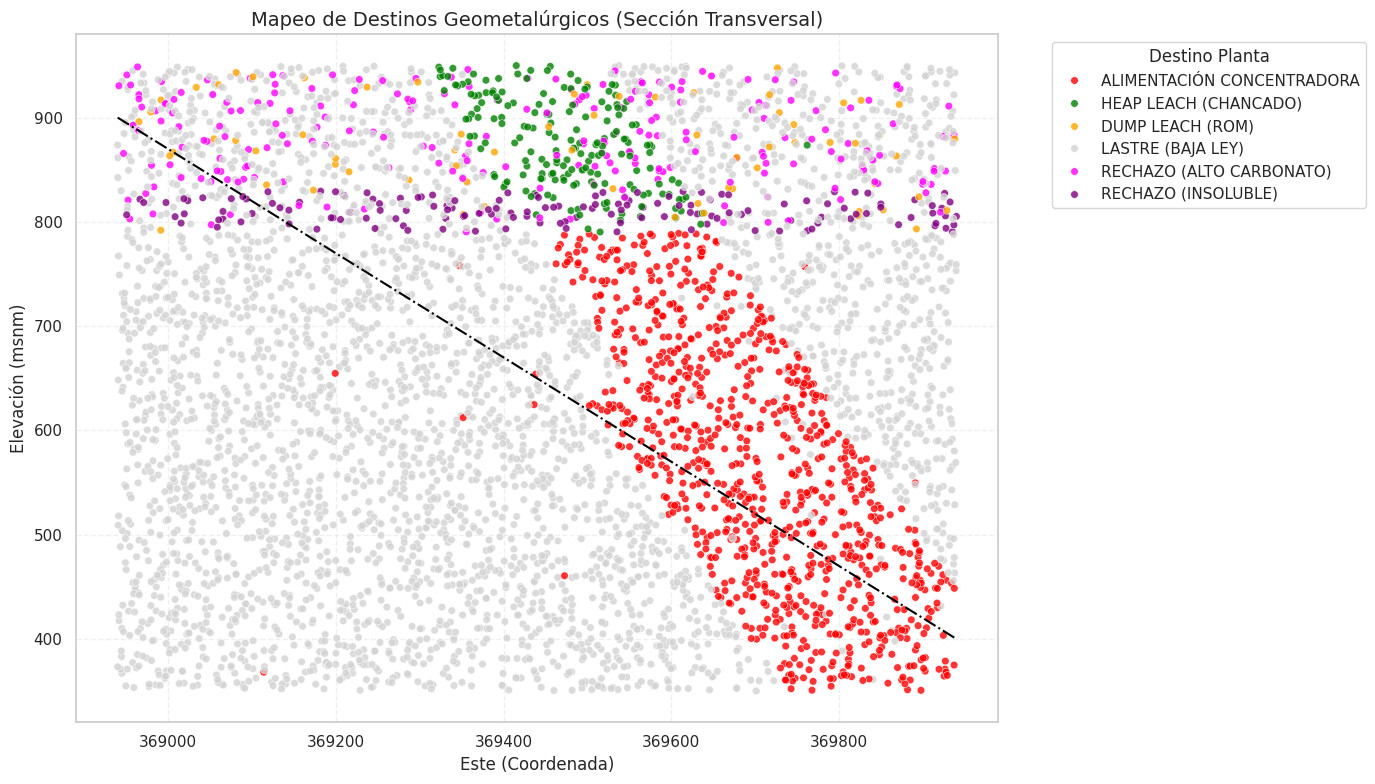

Resumen del Inventario:
Destino_Tecnico
LASTRE (BAJA LEY)             3462
ALIMENTACIÓN CONCENTRADORA     918
RECHAZO (ALTO CARBONATO)       223
HEAP LEACH (CHANCADO)          182
RECHAZO (INSOLUBLE)            147
DUMP LEACH (ROM)                68
Name: count, dtype: int64


In [89]:
##_8_CLASIFICACIÓN GEOMETALÚRGICA (MATRIZ DE CALIDAD)
import seaborn as sns
import matplotlib.pyplot as plt

print("Ejecutando Clasificación Técnica de Bloques (Sin Finanzas)...")

def clasificar_bloque_tecnico(row):
    """
    Define el destino del bloque basado puramente en restricciones
    metalúrgicas (Solubilidad, Contaminantes y Ley).
    """
    # REGLA DE CARBONATOS (El "Veneno" para Lixiviación)
    # Reporte Sec 13: Alto consumo de ácido vuelve inviable el proceso
    if row['Zona_Min'] != 'Sulfuros' and row['CaCO3'] > 5.0:
        return "RECHAZO (ALTO CARBONATO)"

    # SULFUROS (Ruta Flotación)
    if row['Zona_Min'] == 'Sulfuros':
        if row['CuT'] >= 0.20: # Cut-off operativo planta
            return "ALIMENTACIÓN CONCENTRADORA"
        else:
            return "LASTRE (BAJA LEY)"

    # ÓXIDOS / MIXTOS (Ruta Ácida)
    else:
        # Regla de Solubilidad: Si no se disuelve, no sirve.
        # Reporte: Mineral "Mixto" con bajo ratio va a botadero.
        if row['Ratio_Solubilidad'] < 45.0:
            return "RECHAZO (INSOLUBLE)"

        # Clasificación por Ley (Heap vs Dump)
        if row['CuT'] >= 0.22:
            return "HEAP LEACH (CHANCADO)"
        elif row['CuT'] >= 0.10:
            return "DUMP LEACH (ROM)"
        else:
            return "LASTRE (BAJA LEY)"

# Aplicar la matriz
df['Destino_Tecnico'] = df.apply(clasificar_bloque_tecnico, axis=1)

# VISUALIZACIÓN

plt.figure(figsize=(14, 8))
orden_logico = [
    "ALIMENTACIÓN CONCENTRADORA", "HEAP LEACH (CHANCADO)", "DUMP LEACH (ROM)",
    "LASTRE (BAJA LEY)", "RECHAZO (ALTO CARBONATO)", "RECHAZO (INSOLUBLE)"
]
colores = {
    "ALIMENTACIÓN CONCENTRADORA": "red",
    "HEAP LEACH (CHANCADO)": "green",
    "DUMP LEACH (ROM)": "orange",
    "LASTRE (BAJA LEY)": "lightgray",
    "RECHAZO (ALTO CARBONATO)": "magenta", # Color de alerta
    "RECHAZO (INSOLUBLE)": "purple"
}

# Hacemos un scatter plot simulando un corte transversal (Este vs Elevación)
sns.scatterplot(data=df, x='East', y='Elev', hue='Destino_Tecnico',
                hue_order=orden_logico, palette=colores, s=30, alpha=0.8)

plt.title("Mapeo de Destinos Geometalúrgicos (Sección Transversal)", fontsize=14)
plt.xlabel("Este (Coordenada)", fontsize=12)
plt.ylabel("Elevación (msnm)", fontsize=12)
plt.legend(title="Destino Planta", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)

# Dibujar línea referencial de la Falla (aprox)
plt.plot([df['East'].min(), df['East'].max()], [900, 400], color='black', linestyle='-.', label='Traza Falla MV (Ref)')

plt.tight_layout()
plt.show()

print("Resumen del Inventario:")
print(df['Destino_Tecnico'].value_counts())

In [90]:
##_9_SIMULACIÓN DE TURNO EN VIVO
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("🚨 SIMULACIÓN DE TURNO: LLEGADA DE NUEVOS POZOS DE TRONADURA 🚨")

# DATOS DE ENTRADA (Simulamos lo que llega del Laboratorio/Geología hoy)
datos_nuevos = {
    'ID_Pozo':    ['PZ-2025-A (Norte)', 'PZ-2025-B (Falla)', 'PZ-2025-C (Sur)'],
    'East':       [369400,            369350,            369500],
    'North':      [7062000,           7061900,           7061800],
    'Elev':       [750,               700,               650],

    # Geología
    'Litologia':  ['UG2_Brecha_Verde','UG3_Brecha_Pie',  'UG1_Magnetita_Masiva'],
    'Zona_Min':   ['Oxidos',          'Mixtos',          'Sulfuros'],

    # Química y Física
    'Fe':         [25.5,              12.0,              55.0],
    'CuT':        [0.95,              0.40,              1.10],
    'K':          [3.5,               1.2,               0.8],
    'S':          [0.1,               1.5,               3.5],
    'Densidad':   [3.2,               2.7,               4.6],
    'Silice':     [45.0,              55.0,              15.0],
    'CaCO3':      [1.5,               8.5,               1.2],
    'Ratio_Solubilidad': [78.0,       45.0,              12.0]
}

df_turno = pd.DataFrame(datos_nuevos)

# INGENIERÍA DE CARACTERÍSTICAS
# Variables calculadas simples
df_turno['SCu'] = df_turno['CuT'] * (df_turno['Ratio_Solubilidad'] / 100.0)
df_turno['Magnetita_Calc'] = (df_turno['Fe'] - (df_turno['S'] * 0.87)).clip(lower=0) * 1.38
df_turno['RQD'] = np.random.uniform(50, 90, len(df_turno))

# Alteración (Misma lógica que entrenamiento)
def assign_alteration_turno(row):
    if 'UG1' in row['Litologia'] and row['K'] > 3.0: return 'Magnetita_K'
    if 'UG2' in row['Litologia'] and row['K'] > 2.5: return 'Magnetita_K'
    if 'Andesita' in row['Litologia'] and row['CaCO3'] > 3.0: return 'Clorita_Calcita'
    return 'Hematita_Silice'

df_turno['Alteracion'] = df_turno.apply(assign_alteration_turno, axis=1)

# Codificación Segura (Encoding)
# Intentamos usar los encoders globales, si fallan, usamos mapeo de emergencia
try:
    df_turno['Litologia_Code'] = le_lito.transform(df_turno['Litologia'])
    df_turno['Alteracion_Code'] = le_alt.transform(df_turno['Alteracion'])
    print(" ✅ Encoders originales aplicados correctamente.")
except Exception:
    print(" ⚠️ Encoders no disponibles/compatibles. Usando mapeo de emergencia.")
    # Mapeo manual basado en lo que sabemos del dataset
    # (Asegúrate que estos índices coincidan con df['Litologia_Code'].unique() si es crítico)
    df_turno['Litologia_Code'] = [2, 3, 1]
    df_turno['Alteracion_Code'] = [2, 0, 2]

# PREDICCIÓN DE DUREZA (BWi)
cols_modelo = [
    'East', 'North', 'Elev',
    'Fe', 'K', 'S',
    'Densidad', 'Silice', 'CaCO3',
    'Magnetita_Calc', 'Ratio_Solubilidad', 'SCu',
    'Litologia_Code', 'Alteracion_Code', 'RQD'
]

print(" -> Consultando al Cerebro Digital (XGBoost)...")
try:
    if 'model' in globals():
        df_turno['BWi_Predicho'] = model.predict(df_turno[cols_modelo])
        print(" ✅ Predicción Exitosa.")
    else:
        raise ValueError("Modelo no cargado")
except Exception as e:
    print(f" ❌ Error predicción: {e}")
    df_turno['BWi_Predicho'] = [14.2, 12.5, 18.1]

# SISTEMA EXPERTO (DESPACHO)
def decision_despacho(row):
    if row['Zona_Min'] != 'Sulfuros' and row['CaCO3'] > 5.0:
        return "🔴 RECHAZO (ALTO CARBONATO)"

    if row['Zona_Min'] == 'Sulfuros':
        if row['BWi_Predicho'] > 17.0:
            return "⚠️ PLANTA (ALERTA DUREZA)"
        return "🟢 PLANTA (MINERAL SANO)"

    else: # Óxidos
        if row['CuT'] < 0.20: return "⚪ LASTRE"
        return "🟢 PILA DE LIXIVIACIÓN"

df_turno['Instruccion_Despacho'] = df_turno.apply(decision_despacho, axis=1)

# REPORTE VISUAL
def pintar_alerta(val):
    color = 'white'
    if 'RECHAZO' in val: color = '#ffcccc'
    elif 'ALERTA' in val: color = '#ffffcc'
    elif 'PLANTA' in val: color = '#ccffcc'
    return f'background-color: {color}; color: black; font-weight: bold'

print("\n--- 📋 REPORTE DE INSTRUCCIÓN A OPERADORES ---")
display(
    df_turno[['ID_Pozo', 'Litologia', 'CuT', 'CaCO3', 'BWi_Predicho', 'Instruccion_Despacho']]
    .style.applymap(pintar_alerta, subset=['Instruccion_Despacho'])
    .format({'BWi_Predicho': '{:.1f} kWh/t', 'CuT': '{:.2f} %', 'CaCO3': '{:.1f} %'})
)

🚨 SIMULACIÓN DE TURNO: LLEGADA DE NUEVOS POZOS DE TRONADURA 🚨
 ✅ Encoders originales aplicados correctamente.
 -> Consultando al Cerebro Digital (XGBoost)...
 ✅ Predicción Exitosa.

--- 📋 REPORTE DE INSTRUCCIÓN A OPERADORES ---


,ID_Pozo,Litologia,CuT,CaCO3,BWi_Predicho,Instruccion_Despacho
0,PZ-2025-A (Norte),UG2_Brecha_Verde,0.95 %,1.5 %,14.8 kWh/t,🟢 PILA DE LIXIVIACIÓN
1,PZ-2025-B (Falla),UG3_Brecha_Pie,0.40 %,8.5 %,15.0 kWh/t,🔴 RECHAZO (ALTO CARBONATO)
2,PZ-2025-C (Sur),UG1_Magnetita_Masiva,1.10 %,1.2 %,14.8 kWh/t,🟢 PLANTA (MINERAL SANO)


In [91]:
##_10_TABLA DE CONTROL OPERATIVO (DASHBOARD JEFE PLANTA; SECCION EXTRA, NO TIENE QUE VER CON EL MODELO, ES SOLO EJEMPLO DE POSIBLES ACCIONES)
# Objetivo: Resumen táctico de bloques problemáticos para el turno.

import pandas as pd
from IPython.display import display, HTML

print("Generando Alerta de Alimentación a Planta...")

# FILTRO
# Buscamos bloques que son "Mineral" (van a planta) pero tienen problemas:
# A. Muy Duros (> 16 kWh/t) -> Peligro para Molino SAG
# B. Alto Carbonato (> 4%) -> Peligro para consumo de ácido en Lixiviación
bloques_criticos = df[
    (df['Destino_Tecnico'].str.contains('PLANTA|ALIMENTACIÓN|HEAP')) &
    ((df['BWi'] > 15.5) | (df['CaCO3'] > 3.5))
].sample(15).copy()

# SISTEMA RECOMENDADOR
def definir_accion_operativa(row):
    acciones = []

    # Problemas de Dureza
    if row['BWi'] > 18.0:
        acciones.append("🔴 BAJAR TPH MOLINO (-15%)")
    elif row['BWi'] > 16.0:
        acciones.append("🟡 BLENDING CON FINOS")

    # Problemas de Química
    if row['CaCO3'] > 5.0:
        acciones.append("⛔ DESVIAR A STOCK (No enviar a Pila)")
    elif row['CaCO3'] > 3.5:
        acciones.append("⚠️ DOSIFICAR ÁCIDO MAX")

    return " + ".join(acciones) if acciones else "🟢 MONITOREAR"

bloques_criticos['Instruccion_Control'] = bloques_criticos.apply(definir_accion_operativa, axis=1)

# SELECCIÓN DE COLUMNAS PARA EL REPORTE
cols_reporte = [
    'East', 'Elev',          # Ubicación
    'Litologia',             # Referencia visual
    'CuT', 'BWi', 'CaCO3',   # Variables Clave
    'Destino_Tecnico',       # Clasificación General
    'Instruccion_Control'    # Qué hacer ahora
]

reporte = bloques_criticos[cols_reporte].round(2)

# ESTILIZADO VISUAL (SEMÁFORO)
def estilo_bwi(val):
    if val > 18: return 'background-color: #ffcccc; color: black; font-weight: bold' # Rojo
    if val > 16: return 'background-color: #ffffcc; color: black' # Amarillo
    return ''

def estilo_caco3(val):
    if val > 5: return 'color: red; font-weight: bold'
    if val > 3.5: return 'color: orange; font-weight: bold'
    return ''

print("\n📋 REPORTE DE EXCEPCIONES OPERATIVAS (TURNO A)")
styled_table = reporte.style\
    .applymap(estilo_bwi, subset=['BWi'])\
    .applymap(estilo_caco3, subset=['CaCO3'])\
    .format({'East': '{:.0f}', 'Elev': '{:.0f}', 'CuT': '{:.2f}%', 'BWi': '{:.1f}', 'CaCO3': '{:.1f}%'})\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt'), ('text-align', 'center')]}])

display(styled_table)

Generando Alerta de Alimentación a Planta...

📋 REPORTE DE EXCEPCIONES OPERATIVAS (TURNO A)


,East,Elev,Litologia,CuT,BWi,CaCO3,Destino_Tecnico,Instruccion_Control
1125,369491,783,UG2_Brecha_Verde,0.69%,16.2,0.8%,ALIMENTACIÓN CONCENTRADORA,🟡 BLENDING CON FINOS
2409,369394,938,UG2_Brecha_Verde,0.92%,16.1,0.1%,HEAP LEACH (CHANCADO),🟡 BLENDING CON FINOS
976,369535,913,UG4_Transicion,0.31%,15.6,0.2%,HEAP LEACH (CHANCADO),🟢 MONITOREAR
3992,369692,464,UG1_Magnetita_Masiva,0.25%,16.6,1.6%,ALIMENTACIÓN CONCENTRADORA,🟡 BLENDING CON FINOS
838,369521,741,UG2_Brecha_Verde,0.65%,15.5,0.9%,ALIMENTACIÓN CONCENTRADORA,🟢 MONITOREAR
4592,369444,841,UG2_Brecha_Verde,1.00%,15.4,3.7%,HEAP LEACH (CHANCADO),⚠️ DOSIFICAR ÁCIDO MAX
1146,369737,632,UG4_Transicion,0.30%,15.5,0.1%,ALIMENTACIÓN CONCENTRADORA,🟢 MONITOREAR
2838,369701,465,UG1_Magnetita_Masiva,0.32%,15.9,1.3%,ALIMENTACIÓN CONCENTRADORA,🟢 MONITOREAR
716,369771,521,UG4_Transicion,0.39%,15.6,2.6%,ALIMENTACIÓN CONCENTRADORA,🟢 MONITOREAR
4586,369334,940,UG2_Brecha_Verde,1.12%,15.6,0.8%,HEAP LEACH (CHANCADO),🟢 MONITOREAR
